In [1]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
%matplotlib nbagg
import glob
import os.path as op
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

from fastmri_recon.config import *
from fastmri_recon.data.data_utils import from_file_to_kspace
from fastmri_recon.helpers.fourier import fft, ifft
from fastmri_recon.helpers.nn_mri import tf_fastmri_format
from fastmri_recon.helpers.utils import gen_mask, normalize_instance, crop_center
from learning_wavelets.keras_utils.fourier import (
    tf_masked_shifted_normed_fft2d, tf_masked_shifted_normed_ifft2d,
    tf_shifted_normed_fft2d, tf_shifted_normed_ifft2d)
from learning_wavelets.models.ista import IstaLearnlet

In [4]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

<IPython.core.display.Javascript object>


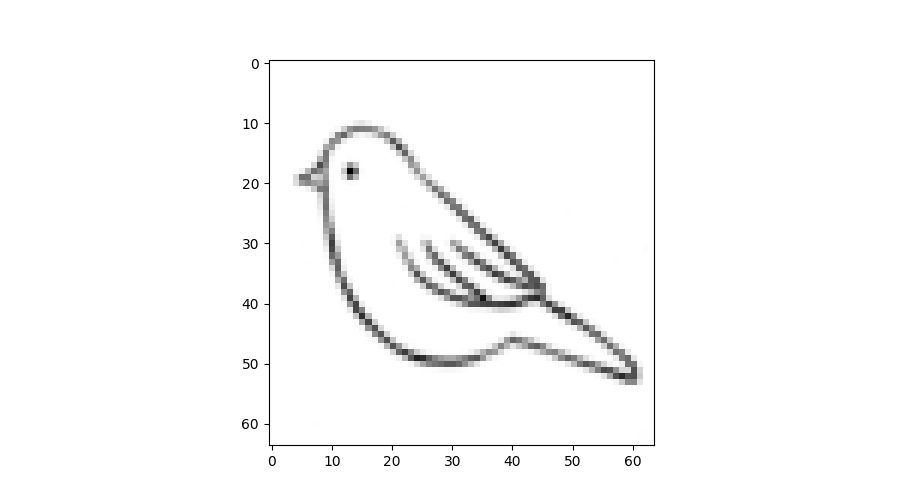

In [5]:
spades = rgb2gray(mpimg.imread('experiments/ista_learnlets/bird.jpg'))
# spades = spades[200:1000, :]
spade_size = 64
spades = resize(spades, (spade_size, spade_size), anti_aliasing=True)
plt.figure()
plt.imshow(spades)

<IPython.core.display.Javascript object>


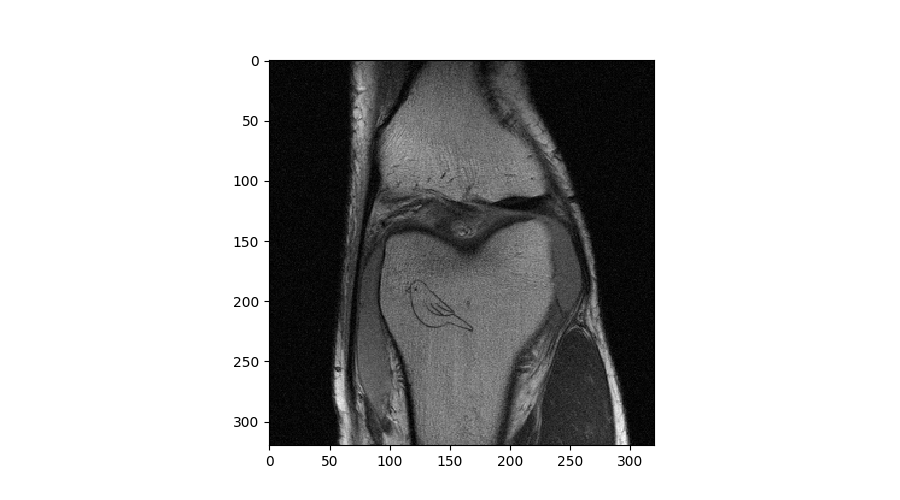

In [6]:
# paths
val_path = f'{FASTMRI_DATA_DIR}singlecoil_val/'
filenames = glob.glob(val_path + '*.h5')
af = 4
kspace = from_file_to_kspace(filenames[150]) * 1e6
selected_slice = 15
kspace = kspace[selected_slice]
image = ifft(kspace).astype(kspace.dtype)
image[332:332 + spade_size, 132:132 + spade_size] *= spades
plt.figure()
plt.imshow(crop_center(np.abs(image), 320))

In [7]:
kspace_spades = fft(image).astype(np.complex64)
mask = gen_mask(kspace_spades, af).astype(kspace_spades.dtype)
kspace_spades = kspace_spades * mask
kspace = kspace * mask
kspace_mask_spades = (kspace_spades[None, ..., None], mask[None, ...])
kspace_mask = (kspace[None, ..., None], mask[None, ...])
image = image[None, ..., None]

In [8]:
learnlet_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 16, 
        'mixing_details': False,    
        'skip_connection': True,
        'kernel_size': 7,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
        'kernel_size': 9,
    },
    'threshold_kwargs':{
        'noise_std_norm': False,
        'alpha_init': 2.0,
    },
    'n_scales': 4,
    'n_reweights_learn': 1,
    'exact_reconstruction': True,
    'undecimated': True,
    'clip': False,
}

model = IstaLearnlet(
    n_iterations=5,
    forward_operator=tf_masked_shifted_normed_fft2d,
    adjoint_operator=tf_masked_shifted_normed_ifft2d,
    postprocess=tf_fastmri_format,
    fista_mode=True,
    **learnlet_params,
)
model([tf.zeros((1, 640, 320, 1), dtype=tf.complex64), tf.zeros((1, 640, 320), dtype=tf.complex64)])
model.load_weights(
    'checkpoints/fista_learnlet_fastmri_16_5_dynamic_soft_thresholding_1583847877-300.hdf5',
)

In [9]:
res = model(kspace_mask)
res_spades = model(kspace_mask_spades)

<IPython.core.display.Javascript object>


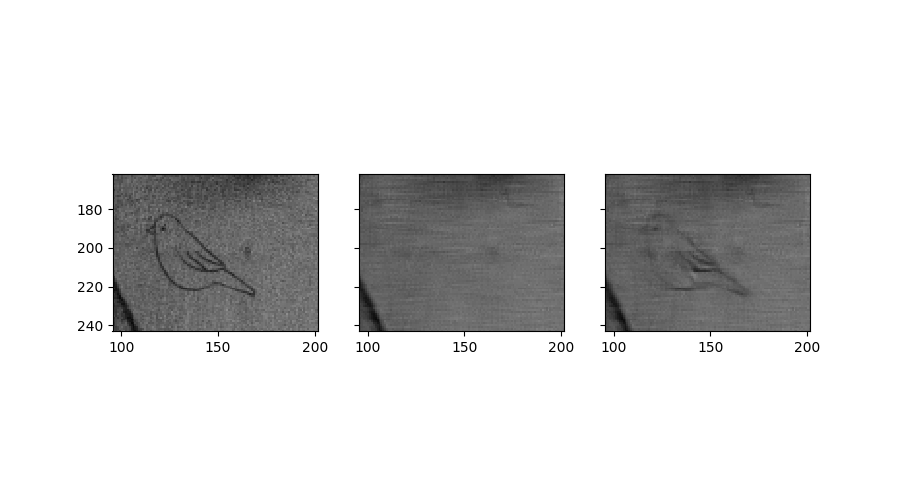

In [10]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].imshow(crop_center(np.abs(image[0, ..., 0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[1].imshow(np.abs(res[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[2].imshow(np.abs(res_spades[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))

In [11]:
from fastmri_recon.models.cascading import cascade_net

run_params = {
    'n_cascade': 5,
    'n_convs': 5,
    'n_filters': 48,
    'noiseless': True,
}

cascade_model = cascade_net(**run_params)
cascade_model.load_weights('/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/checkpoints/cascadenet_af4_1568926824-300.hdf5')

In [12]:
res_cascade = cascade_model(kspace_mask)
res_cascade_spades = cascade_model(kspace_mask_spades)

<IPython.core.display.Javascript object>


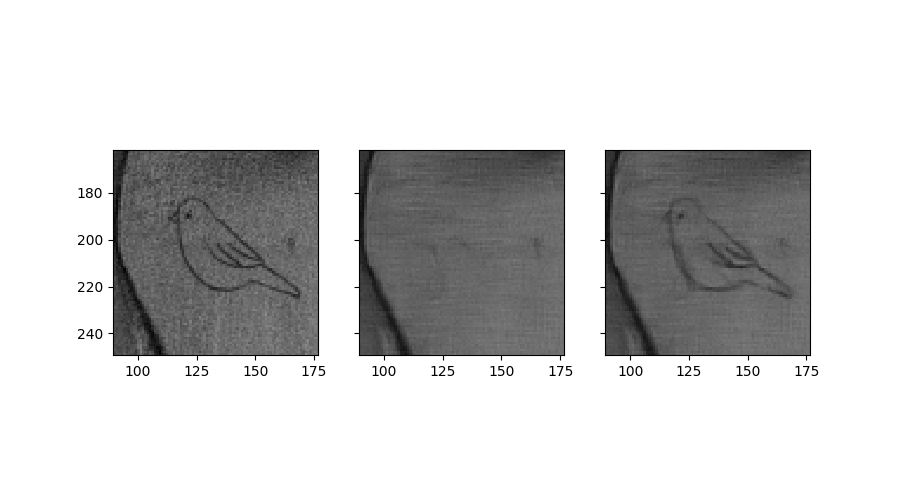

In [13]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].imshow(crop_center(np.abs(image[0, ..., 0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[1].imshow(np.abs(res_cascade[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[2].imshow(np.abs(res_cascade_spades[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))

In [14]:
from fastmri_recon.models.unet import unet

run_params = {
    'n_layers': 4,
    'pool': 'max',
    "layers_n_channels": [16, 32, 64, 128],
    'layers_n_non_lins': 2,
    'input_size': (320, 320, 1),
}

unet_model = unet(**run_params)
unet_model.load_weights('/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/checkpoints/unet_af4_1569210349-300.hdf5')

In [15]:
z_filled = np.abs(ifft(kspace_mask[0][0, ..., 0])).astype(np.float32)
z_filled, mean, std = normalize_instance(crop_center(z_filled, 320), eps=1e-11)
z_filled = z_filled[None, ..., None]

z_filled_spades = np.abs(ifft(kspace_mask_spades[0][0, ..., 0])).astype(np.float32)
z_filled_spades, mean_spades, std_spades = normalize_instance(crop_center(z_filled_spades, 320), eps=1e-11)
z_filled_spades = z_filled_spades[None, ..., None]

res_unet = unet_model(z_filled) * std + mean
res_unet_spades = unet_model(z_filled_spades) * std_spades + mean_spades

<IPython.core.display.Javascript object>


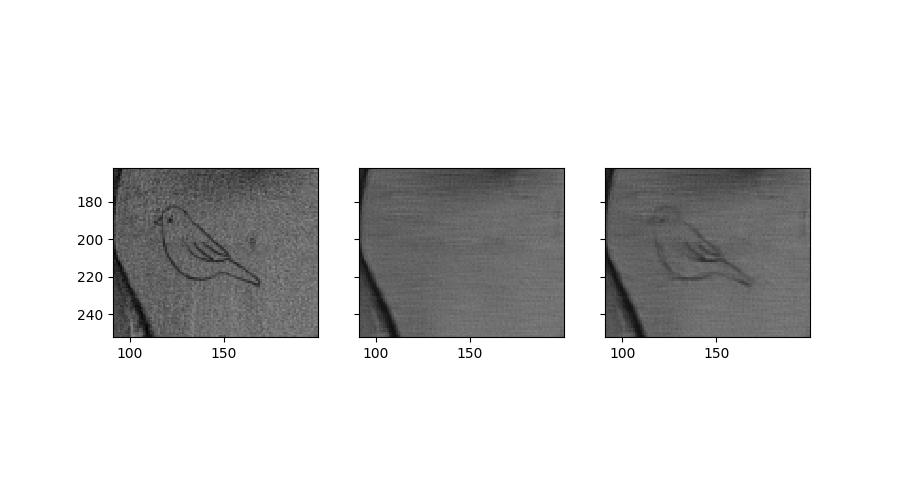

In [16]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].imshow(crop_center(np.abs(image[0, ..., 0]), 320), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[1].imshow(np.abs(res_unet[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))
axs[2].imshow(np.abs(res_unet_spades[0, ..., 0]), vmin=np.min(np.abs(image[0])), vmax=np.max(np.abs(image[0])))